In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%load_ext slim_magic

In [3]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [8, 4]

# SLiM

SLiM stands for ["Selection on Linked Mutations"](https://messerlab.org/slim/),
written by Ben Haller and Phillip Messer.
The manual is very good, and probably describes everything you'd want to know,
but there are published papers about [SLiM v2](https://academic.oup.com/mbe/article/34/1/230/2670194),
[SLiM v3](https://academic.oup.com/mbe/advance-article/doi/10.1093/molbev/msy228/5229931),
using [tree sequence recording](https://onlinelibrary.wiley.com/doi/abs/10.1111/1755-0998.12968),
and a [tutorial for SLiM v3](https://academic.oup.com/mbe/advance-article/doi/10.1093/molbev/msy237/5258474).

It was initially designed to simulate genomes under selection,
but has matured into a good ecological simulator itself (in v3).
We'll focus on this, but you still need to know the basics of how to set up genomes.

Simulation hierarchy:

- `sim` : the simulation
    - `p1`, `p2`, ... : the "subpopulations"
        - `p1.individuals` : the individuals in subpopulation `p1`
            - `ind.genomes` : the two genomes of individual `ind`
                - `genome.mutations` : the "mutations" carried by `genome`

Most things are vectorized, so for instance `p1.individuals.sex` will get you a vector of sexes,
equivalent to doing something like `for (ind in p1.individuals) { ... ind.sex ... }`.

## Running scripts

First, you need to [install SLiM](https://messerlab.org/SLiM).
You should use SLiM's GUI for developing and visualizing!
But, in this notebook I'll run SLiM from within the notebook.
I'm doing this with the `slim_magic` package, in development; get this by doing (anywhere):
```
git clone https://github.com/andrewkern/slim_magic.git
cd slim_magic
pip install .
```

### A first recipe

Here's the first recipe from the SLiM manual.
It uses the default demography: a randomly-mating Wright-Fisher population of fixed size.
The `%%slim` up top of this cell asks python to run the SLiM script and print the resulting output.

In [4]:
%%slim
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(1e-7);

    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // m2 mutation type: beneficial
    initializeMutationType("m2", 0.5, "f", 0.01);

    // g1 genomic element type: uses m1 or m2 with equal prob for mutations
    initializeGenomicElementType("g1", c(m1, m2), c(1.0, 1.0));

    // uniform chromosome of length 100 kb
    initializeGenomicElement(g1, 0, 99999);
   
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-8);
}

// create a population of 500 individuals
1 {
    sim.addSubpop("p1", 500);
}

// run to generation 10000
10000 {
    sim.simulationFinished();
}

// Initial random seed:
5966568885072

// RunInitializeCallbacks():
initializeMutationRate(1e-07);
initializeMutationType(1, 0.5, "f", 0);
initializeMutationType(2, 0.5, "f", 0.01);
initializeGenomicElementType(1, c(m1, m2), c(1, 1));
initializeGenomicElement(g1, 0, 99999);
initializeRecombinationRate(1e-08);

// Starting run at generation <start>:
1 




**Exercise:** Put this in the SLiM GUI.
1. Run it.
2. Click on the "help" button and browse the functions.
3. Option-click on a function to pop up the help for it.
4. Change the mutation type to be *deleterious*, like so:
```
    initializeMutationType("m1", 0.5, "f", -0.01);
```
and watch what happens.

## More general (non-Wright-Fisher) models

There are two general types: "Wright-Fisher" and "non-Wright-Fisher".
(Wright-Fisher is a special case of non-Wright-Fisher, but it came first, thus the name.)
We want to have real demography, so we'll stick to "nonWF" models.

### The SLiM Life Cycle

The most important thing to understand is the life cycle. 
The life cycle for Wright-Fisher models is a bit different (see the manual),
but for nonWF models it is, a bit simplified:

1. Generation of offspring, in `reproduction()` callbacks
    
2. Execution of `early()` events

3. Fitness value recalculation with `fitness()` callbacks

4. Viability/survival selection (`fitness` = probability of survival)

5. Removal of fixed mutations

6. Execution of `late()` events

7. Generation count increment, individual age increments

### The parts of a recipe

Each *script block* in a SLiM recipe
is prefaced with some code that says *when* it happens, and to *whom*.
This might take the form:
```
[id] [gen1 [: gen2]] [early()] { ... }
```
The square brackets demarcate optional things.
The pieces are:

- `id` : a name for this script block (often omitted)
- `gen1` : the first time step to execute this code in
- `gen2` : the last time step to execute this code in
- `early()` : when in the life cycle this happens; can actually be one of 
    `initialize()`, `early()`, `late()`, `fitness()`, `interaction()`,
    `mateChoice()`, `modifyChild()`, `recombination()`, or `reproduction()`
    (defaults to `early()`).

These have somewhat different meanings: for instance,
an `early()` script block happens once per time step,
a `modifyChild()` script block is evaluated once *per offspring* each time step.
Also, many of these can be restricted to a subset of indivduals.

For instance:
```
early() {
    // stuff here happens every early()
}
```
or,
```

10:20 reproduction(p1) {
    // stuff here happens every time step from 10 to 20 (inclusive)
    // and only to individuals in subpopulation p1
}
```

### A nonWF model

Here's an example nonWF model.
The new things are that

1. We need to explicitly manage reproduction (with a `reproduction()` callback).
2. We put in some output, that reports what the current population size is every time step.
   (This is sent to python using the `%%slim_stats` magic.) 

In [5]:
%%slim_stats
initialize()
{
    // since the default is WF, to get a non-WF model, we need to say so
    initializeSLiMModelType("nonWF");
    // genome is the same as above
    initializeMutationRate(1e-7);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", m1, 1.0);
    initializeGenomicElement(g1, 0, 99999);
    initializeRecombinationRate(1e-8);    
}

reproduction() {
    subpop.addCrossed(individual, subpop.sampleIndividuals(1));
}

1 early() {
    sim.addSubpop("p1", 10);
    log = sim.createLogFile("/dev/stdout", logInterval=1);
    log.addGeneration();
    log.addCustomColumn("pop_size", "p1.individualCount;"); 
}

10 {
    sim.simulationFinished();
}

,pop_size
generation,
1,10
2,20
3,40
4,80
5,160
6,320
7,640
8,1280
9,2560


### SLiM's Fitness

Uh-oh, I see where *that* is going.
We need population regulation!
The easiest way is by the `fitnessScaling` attribute of individuals.
In nonWF SLiM models, the "fitness" of an individual 
is the probability of survival until the next time step.
This is computed by multiplying the fitness calculated from the genome
(since all our mutations are neutral, this is `1.0` for everyone)
by the `fitnessScaling` attributes of the individual and of their subpopulation.

Concretely, we'll fix a "carrying capacity" $K$,
and say that the probability of survival, per individual,
when there are $N$ individuals, is $K/N$.

As before, every individual produces one offspring
with a randomly chosen mate
every time step.

**Exercise:** What is the stable population size of this model?
Predict before you run it.

In [6]:
%%slim_stats --out df
initialize()
{
    // since the model will be non-Wright-Fisher, we need to say so
    initializeSLiMModelType("nonWF");
    // genome is the same as above
    initializeMutationRate(1e-7);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", m1, 1.0);
    initializeGenomicElement(g1, 0, 99999);
    initializeRecombinationRate(1e-8);    

    // this will be the carrying capacity
    defineConstant("K", 1000);
}

reproduction() {
    subpop.addCrossed(individual, subpop.sampleIndividuals(1));
}

1 early() {
    sim.addSubpop("p1", 1000);
    log = sim.createLogFile("/dev/stdout", logInterval=1);
    log.addGeneration();
    log.addCustomColumn("pop_size", "p1.individualCount;");
}

early() {
    p1.fitnessScaling = K / p1.individualCount;
}

100 {
    sim.simulationFinished();
}

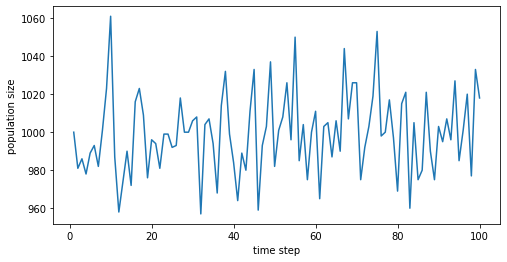

In [7]:
fig, ax = plt.subplots()
ax.plot(df)
ax.set_xlabel("time step")
ax.set_ylabel("population size");

**Exercise:** Add to the output another entry: how many individuals are older than 2 time steps.
(Code like it's R;
`p1.individuals` gets you a vector of individuals; 
look in the help under Individual to see how to get their ages.)

## Age-dependent mortality

Let's modify the above to resemble our *stage-structured* model from before.

1. Individuals are *juvenile* for one full year, with 70% mortality rate.
2. If they survive, they become *adults*, with 50% yearly mortality,
3. and a mean birth rate of 10 per individual.

This will grow exponentially, of course, so don't run it for too long.

In [11]:
%%slim_stats --out df
initialize() {
    initializeSLiMModelType("nonWF");
    initializeMutationRate(1e-7);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", m1, 1.0);
    initializeGenomicElement(g1, 0, 99999);
    initializeRecombinationRate(1e-8);    

    // this will be the carrying capacity
    defineConstant("K", 100);
}

reproduction() {
    if (individual.age > 1) {
        num_offspring = rpois(1, 10);
        mate = sample(p1.individuals[p1.individuals.age > 1], 1);
        // catn("Producing " + num_offspring + " babies!");
        for (k in seqLen(num_offspring)) {
            p1.addCrossed(individual, mate);
        }
    }
}

1 early() {
    sim.addSubpop("p1", 500);
    log = sim.createLogFile("/dev/stdout", logInterval=1);
    log.addGeneration();
    for (age in seqLen(10)) {
        log.addCustomColumn("age_" + age, "sum(p1.individuals.age == " + age + ");");
    }
}


early() {
    // survival probabilities
    inds = p1.individuals;
    inds[inds.age > 1].fitnessScaling = 0.5;
    inds[inds.age <= 1].fitnessScaling = 0.3;
}

10 {
    sim.simulationFinished();
}

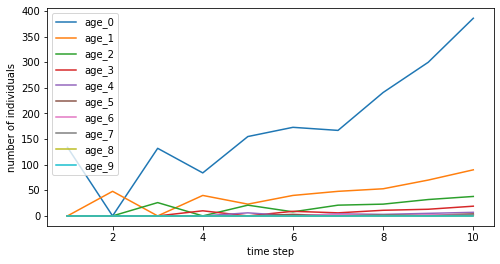

In [9]:
fig, ax = plt.subplots()
ax.plot(df, label=df.columns)
ax.set_xlabel("time step")
ax.set_ylabel("number of individuals")
ax.legend();

**Exercise:** change `%%slim_stats` to `%%slim` at the top and uncomment the `catn( )` line; see what happens. (Moral: to get useful debugging output, use `catn( )`!)

**Exercise:**  Add *fecundity* population regulation to this model:
suppose that the mean number of offspring that an individual has
when there are $N$ adults is $10/(1 + N/K)$, where $K$ is the carrying capacity.
Predict where equilibrium will be, then run it for 1000 generations to see.

### Exercise

Read sections 1-4 of the SLiM Manual.
Add *both* beneficial and deleterious mutations to a SLiM recipe of your choice.
(You should be able to tell this is working if you get fitness values both above and below 1.)